In [2]:
import os
os.chdir("../")
print(os.getcwd())

d:\PhD_Projects


In [3]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd


ModuleNotFoundError: No module named 'src'

In [4]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/Exp3.2_Transient_2DCyl_Numobstest_ts29_T200_localtest_deactivate_seqmodel"  #Experiment Directory
# exp_name  = "sl32_nhu40_numobs8_bs16_lr5e-5"                #One of the experiment names

models = []
#Non transient data analysis
# exp_name_list = ["sl8_nhu40_numobs2_bs16_lr5e-5_3",\
#                  "sl8_nhu40_numobs3_bs16_lr5e-5_3",\
#                  "sl8_nhu40_numobs4_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs8_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs16_bs16_lr5e-5_2",\
#                  "sl8_nhu40_numobs32_bs16_lr5e-5"]
exp_name_list = [
                 "sl8_nhu40_numobs5_bs16_lr5e-5",\
                 "sl8_nhu40_numobs5_bs16_lr5e-5_ntrans230",\
                 "sl8_nhu40_numobs5_bs16_lr5e-5_ntrans330",\
                 "sl8_nhu40_numobs5_bs16_lr5e-5_ntrans430"
                #  "sl8_nhu40_numobs7_bs16_lr5e-5_ntrans430",\
                #  "sl8_nhu40_numobs8_bs16_lr5e-5_ntrans430",\
                #  "sl8_nhu40_numobs16_bs16_lr5e-5_ntrans430",\
                #  "sl8_nhu40_numobs32_bs16_lr5e-5_ntrans430"
                 ]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl8_nhu40_numobs5_bs16_lr5e-5


NameError: name 'Eval_MZA' is not defined

In [5]:
#Sort Models
# def param_find(model):
#     return model.seq_len
# models.sort(key = param_find)

# for model in models:
#     print(model.exp_name)

#plot learning curves
models[0].plot_learning_curves()

IndexError: list index out of range

In [6]:
#loading weights
# epoch_num = 1700

# #Non Transient data
# for i in range(len(models)):
#     if i==0:
#         epoch_num = 8059
#     elif i == 1:
#         epoch_num = 4999
#     elif i == 7:
#         epoch_num = 2990
#     else:
#         epoch_num = 2990
#     models[i].load_weights(epoch_num)

# # Transient Data with numobs3 and 5
# for i in range(0,len(models)):
#     if i == 0:
#         epoch_num = 4150
#     elif i == 1:
#         epoch_num = 3075
#     elif i == 2:
#         epoch_num = 4000  
#     elif i == 3:
#         epoch_num = 3000
#     elif i == 4:
#         epoch_num = 4600
#     models[i].load_weights(epoch_num)

# Transient Data with numobs5 only
for i in range(0,len(models)):
    ml = False
    # if i == 0:
    #     epoch_num = 4999
    #     ml = True
    if i == 0:
        epoch_num = 3075
    elif i == 1:
        epoch_num = 3000
    elif i == 2:
        epoch_num = 4000  
    elif i == 3:
        epoch_num = 2775
    elif i == 4:
        epoch_num = 3825
    elif i == 5:
        epoch_num = 2200
    elif i == 6:
        epoch_num = 2075
    models[i].load_weights(epoch_num, ml)

# Transient Data with diff num obs 
# for i in range(0,len(models)):
#     ml = False 
#     if i == 0:
#         epoch_num = 2775
#     elif i == 1:
#         ml = True
#     elif i == 2:
#         ml = True
#     elif i == 3:
#         epoch_num = 3825
#     elif i == 4:
#         epoch_num = 2200
#     elif i == 5:
#         epoch_num = 2075
#     models[i].load_weights(epoch_num, ml)

In [7]:
#One Step Prediction
model_num = 3
models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape


IndexError: list index out of range

In [34]:
#Load Data
with open('Data/2DCylinder/processed_data/pklfiles/nektar_cyl_data_20_dt0.25_T200.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [35]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape


((1, 367, 3969), (1, 367, 3969), (1, 367, 3969), (1, 367, 3969))

In [36]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 367)


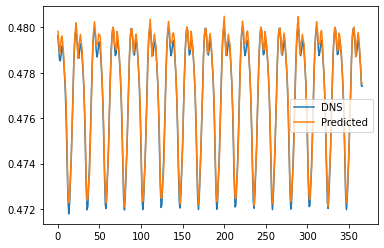

In [37]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

In [ ]:
for i in range(100,150):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_nn[0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-3].exp_dir + "/" + models[-3].exp_name + "/error_pred/")

# plt.axes().set_aspect('equal')

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
#defining moving average
def moving_avg(u):

    pdu  = pd.DataFrame(u)
    u_ma = pdu.expanding().mean()
    return u_ma

# print(u_ma.shape)

# plt.plot(np.arange(u.shape[1]),u[...,0].squeeze(), label = "Mean Energy")
# plt.plot(u_ma)
# # plt.plot(np.arange(ref_X.shape[0]),ref_X_ma, linewidth = 3, label = "Time Moving Average")
# plt.xlabel("Time Units")
# plt.ylabel("Mean Energy")
# plt.legend()

In [ ]:
Phi_nn_hat_ma = moving_avg(Phi_nn_hat.cpu().numpy())

plt.plot(Phi_nn_hat_ma)

In [ ]:
#multistep prediction
timesteps = 300
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_hat = []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i] = models[i].predict_multistep(initial_conditions, timesteps)
    x_hat.append(x_hat_temp)
print(Phi_ms_hat.shape)


In [31]:
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()
U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((4, 1, 301, 3969), (4, 1, 301, 3969), (1, 466, 3969), (1, 466, 3969))

(4, 1, 301)


Text(0, 0.5, 'kinetic energy')

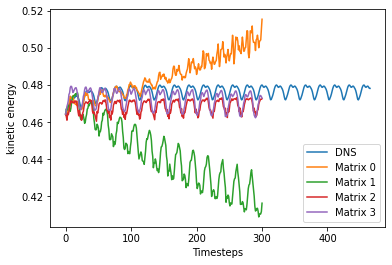

In [32]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
plt.plot(k[0,initial_step:], label = "DNS")
for i in [0,1,2,3]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Matrix {i}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

In [ ]:
for i in range (100,200,5):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_ms_hat[-2,0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    # plt.scatter(sub_X,sub_Y,c = U_ms_hat[-1,0,i], s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-1].exp_dir + "/" + models[-1].exp_name + "/out_log/error_plots/fig"+str(i)+".png")

torch.Size([1, 367, 7938]) torch.Size([8, 1, 301, 7938])


Text(0, 0.5, 'MSE')

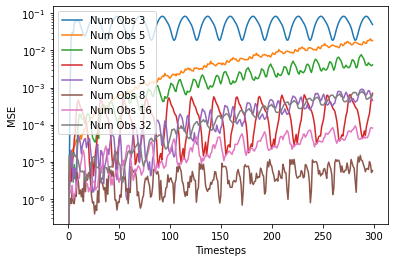

In [17]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0,1,2,3,4,5,6,7]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Matrix {i}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

Text(0, 0.5, 'MSE')

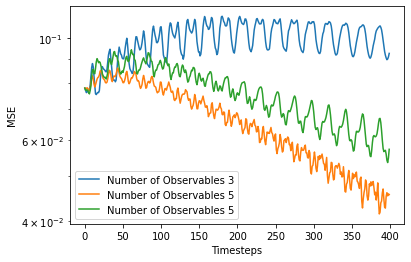

In [67]:
plt.figure()
for i in range(len(models)):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Number of Observables {models[i].num_obs}")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [ ]:
import numpy
k1 = np.load("koopman_numobs4.npy")
k2 = np.load("koopman_numobs16.npy")
k3 = np.load("koopman_numobs32.npy")
k1.shape

plt.figure()
# plt.plot(k1[:,0])
plt.plot(np.linspace(0,101,1001),k2[0,:,1], label = "Koopman")
plt.plot(np.linspace(0,101,1001),Phi_nn[0,:1001,1].cpu().numpy(), label = "Target")
plt.plot(np.linspace(0,101,1001),Phi_hat.cpu().numpy()[0,:,1], label = "MZA Memory = 0.4 timeunits")
# plt.plot(k3[:,0])
plt.legend()
plt.xlabel("Timeunits")
plt.ylabel("u1")
k2.shape

[ 0.9602225 +0.27892092j  0.9602225 -0.27892092j -0.10958467+0.j
 -0.349807  +0.j         -0.6879555 +0.j        ]
[ 1.0000387 +0.j         0.96034884+0.2785528j  0.96034884-0.2785528j
  0.09325693+0.j        -0.4908552 +1.0213603j -0.4908552 -1.0213603j]
[ 0.99791294+0.j          0.959256  +0.27832523j  0.959256  -0.27832523j
 -0.10039608+0.j         -0.40925607+0.59500426j -0.40925607-0.59500426j
 -0.5459735 +0.j        ]
[ 0.99997574+0.j          0.96040016+0.27854347j  0.96040016-0.27854347j
  0.12699158+0.j         -0.06162973+0.j         -0.3090103 +0.86267585j
 -0.3090103 -0.86267585j -0.9500363 +0.j        ]
[ 1.0000309 +0.j          0.9603721 +0.27861694j  0.9603721 -0.27861694j
  0.3531068 +0.j          0.15922838+0.81694543j  0.15922838-0.81694543j
  0.05856049+0.38051096j  0.05856049-0.38051096j  0.03660282+0.j
 -0.15209438+0.21428761j -0.15209438-0.21428761j -0.3689285 +0.8061603j
 -0.3689285 -0.8061603j  -0.40430325+0.3103232j  -0.40430325-0.3103232j
 -0.8649385 +0.j     

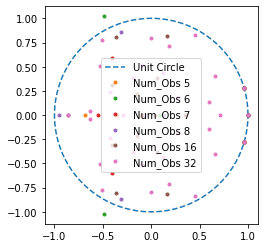

In [15]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [0,1,2,3,4,5]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", label = f"Matrix {i}")


plt.legend()

In [23]:
lamb = np.log(w)/0.25
lamb

array([ 6.7800499e-04 +0.j       , -4.0019583e-04 +1.1282161j,
       -4.0019583e-04 -1.1282161j, -1.3455224e+00 +0.j       ,
       -1.0348327e+00 +2.1891017j, -1.0348327e+00 -2.1891017j,
       -1.9904295e+00 +0.9210083j, -1.9904295e+00 -0.9210083j,
       -2.1150666e-01 +4.277062j , -2.1150666e-01 -4.277062j ,
       -4.4570746e+00 +2.3503885j, -4.4570746e+00 -2.3503885j,
       -1.1972960e+00 +5.262002j , -1.1972960e+00 -5.262002j ,
       -3.2278497e+00 +5.1982565j, -3.2278497e+00 -5.1982565j,
       -9.2805827e-01 +6.301102j , -9.2805827e-01 -6.301102j ,
       -2.5862873e+00 +6.9910326j, -2.5862873e+00 -6.9910326j,
       -3.3995976e+00 +8.118239j , -3.3995976e+00 -8.118239j ,
       -4.9957891e+00+12.566371j , -2.8999610e+00+10.54335j  ,
       -2.8999610e+00-10.54335j  , -3.1263050e-01 +8.621188j ,
       -3.1263050e-01 -8.621188j , -1.2133667e+00 +9.515401j ,
       -1.2133667e+00 -9.515401j , -1.8144181e+00+12.300271j ,
       -1.8144181e+00-12.300271j , -6.0857314e-01+12.56

In [43]:
np.arctan(np.imag(w)/np.real(w))

array([ 0.28236806, -0.28236806,  0.        , -0.        , -0.        ],
      dtype=float32)

In [44]:
error = np.zeros((1,models[-1].num_obs))
for i in range(error.shape[1]):
    error[0,i] = np.linalg.norm(mat*v[:,i] - w[i]*mat,ord="fro")
print(error)

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
#decoding the eigenvectors
print(v.shape)
tv = torch.tensor(np.real(v)).to(models[-2].device)

koopmodes = models[-2].model.autoencoder.recover(tv)
koopmodes.shape

In [ ]:
plt.figure()
plt.scatter(sub_X,sub_Y,c=koopmodes.detach().cpu().numpy()[0,:], s=1, cmap = 'coolwarm')